<a href="https://colab.research.google.com/github/felixsimard/comp551-p2/blob/main/takuya_part1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression
In logistic regression we perform binary classification of by learnig a function of the form $f_w(x) = \sigma(x^\top w)$. Here $x,w \in \mathbb{R}^D$, where $D$ is the number of features as before. $\sigma(z) = \frac{1}{1+e^{-z}}$ is the logistic function.  Let's plot this function below

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'logistic function')

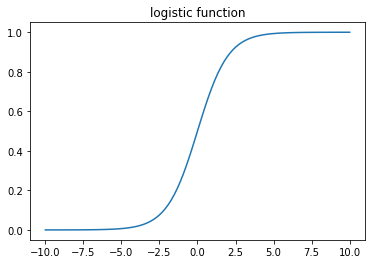

In [2]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('logistic function')

```
#logistic
x [N,D]
w [D]
x@w [N]
logistic(x@w) [N]

#softmax
x [N,D]  R^D->R^C
w [D,C]
logits = x@w [N,C] 
logits = logits - np.max(logits, axis=1)
softmax[j,i] = exp(logits[j,i])/{np.sum(exp(logits), axis=1)+eps}
softmax(x@w) [N,C]
```

## Cost function
To fit our model $f_w$ to the data $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, we maximize the **logarithm of the conditional likelihood**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

by substituting the definition of logistic function in the equation above, and minimizing the **negative** of the log-likelihood, which is called the **cost function**,
we get

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

In practice we use mean rather than sum over data points.

In [3]:
def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

## Minimizing the cost using gradient descent
To minimize the cost we use gradient descent: start from some initial assignment to the parameters $w$, and at each iteration take a small step in the opposite direction of the *gradient*. The gradient of the cost function above is given by:

$$
\frac{\partial}{\partial w_d} J(w) =\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}} = \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} = x^{(n)}_d (\hat{y}^{(n)} - y^{(n)}) 
$$
Since in practice we divide the cost by $N$, we have to the same for the gradient; see the implementation below.

In [4]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

## Logistic regression class
Now we are ready to implement the logistic regression class with the usual `fit` and `predict` methods. Here, the `fit` method implements gradient descent.

In [5]:
import time
import pandas as pd
from sklearn.metrics import accuracy_score

In [122]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        
    def fit(self, x, y):
        start_time = time.process_time()
        if x.ndim == 1:
            x = x[:, None] # 1d to 2d
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)]) # adding a new column with N rows
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        # step when exceeding max iters or gradient becomes too small
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        elapsed_time = time.process_time() - start_time

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
            print(f'time elapsed: {elapsed_time: .2f} seconds')
        return self
    
    def fit_for_vis(self, x, y, val_X, val_y, itv=1e3):
        start_time = time.process_time()
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0

        acc_list = []

        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            if t % itv == 0:
                val_yh = (self.predict(val_X) > 0.5).astype('int')
                acc_list.append(accuracy_score(val_y, val_yh))
            
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            t += 1
        
        elapsed_time = time.process_time() - start_time
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
            print(f'time elapsed: {elapsed_time: .2f} seconds')
        return acc_list

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

## Toy experiment

fit this linear model to toy data with $x \in \Re^1$ + a bias parameter

terminated after 100000 iterations, with norm of the gradient equal to 0.0007886436933334234
the weight found: [-9.96926826 20.27319341]
time elapsed:  3.02 seconds


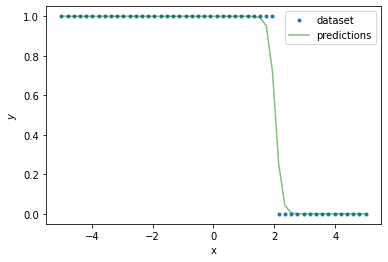

In [7]:
N = 50
x = np.linspace(-5,5, N)
y = ( x < 2).astype(int)                                  #generate synthetic data
model = LogisticRegression(verbose=True, )
yh = model.fit(x,y).predict(x)
plt.plot(x, y, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

we see that the model successfully fits the training data. If we run the optimization for long enough the weights will grow large (in absolute value) so as to make the predicted probabilities for the data-points close to the decidion boundary (x=2) close to zero and one.


## Weight Space
Similar to what we did for linear regression, we plot *cost* as a function for logistic regrression as a function of model parameters (weights), and show the correspondence between the different weights having different costs and their fit. 
The `plot_contour` is the same helper function we used for plotting the cost function for linear regression.

In [8]:
import itertools
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Now let's define the cost function for linear regression example above, and visualize the cost and the fit of various models (parameters).

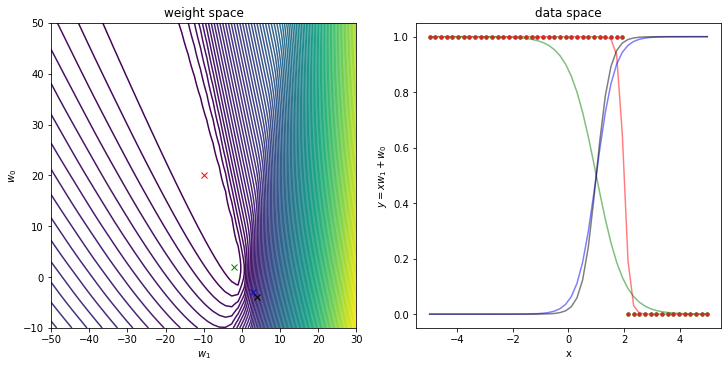

In [9]:
x_plus_bias = np.column_stack([x,np.ones(x.shape[0])])
cost_w = lambda param: cost_fn(x_plus_bias, y, param)           #define the cost just as a function of parameters
model_list = [(-10, 20), (-2, 2), (3,-3), (4,-4)]
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))
plot_contour(cost_w, [-50,30], [-10,50],  50, axes[0])
colors = ['r','g', 'b', 'k']
for i, w in enumerate(model_list):
    axes[0].plot(w[0], w[1], 'x'+colors[i])
    axes[1].plot(x, y, '.')
    axes[1].plot(x, logistic(w[1] + np.dot(w[0], x)), '-'+colors[i], alpha=.5)
axes[0].set_xlabel(r'$w_1$')
axes[0].set_ylabel(r'$w_0$')
axes[0].set_title('weight space')
axes[1].set_xlabel('x')
axes[1].set_ylabel(r'$y=xw_1 + w_0$')
axes[1].set_title('data space')
plt.show()

## Iris dataset
Let's visualize class probabilities for D=2 (plus a bias). 
To be able to use logistic regression we choose two of the three classes in the Iris dataset.

<class 'numpy.ndarray'>


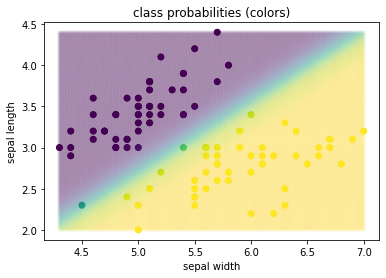

In [10]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,:2], dataset['target']
print(type(x))
x, y = x[y < 2], y[y< 2]                                # we only take the data of class 0 and 1
model = LogisticRegression()
yh = model.fit(x,y).predict(x)

x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
yh_all = model.predict(x_all)
plt.scatter(x[:,0], x[:,1], c=yh, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.05)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('class probabilities (colors)')
plt.show()

# Code added

In [11]:
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
train_df = pd.read_csv('/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_test.csv')

In [95]:
val_df.Outcome.value_counts()

0    65
1    35
Name: Outcome, dtype: int64

## Feature-Target split

In [16]:
# split into feature and target
train_X =  train_df.drop('Outcome', axis=1)
train_y = train_df.loc[:, 'Outcome']
val_X = val_df.drop('Outcome', axis=1)
val_y = val_df.loc[:, 'Outcome']
test_X = test_df.drop('Outcome', axis=1)
test_y = test_df.loc[:, 'Outcome']

In [31]:
def get_acc_list(lr, max_iters, itv):
    model = LogisticRegression(verbose=True, learning_rate=lr, max_iters=max_iters)
    acc_list = model.fit_for_vis(train_X, train_y, val_X, val_y, itv)
    return acc_list

## Visualization

Try the following learning rates: [0.2, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

In [114]:
# configuration
max_iter = 1e6
itv = int(1e3)
lr_list = [0.2, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

In [115]:
# parallerize training
accs_list = Parallel(n_jobs=-1, verbose=10)(delayed(get_acc_list)(i, max_iter, itv) for i in lr_list)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 23.6min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 31.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 31.3min finished


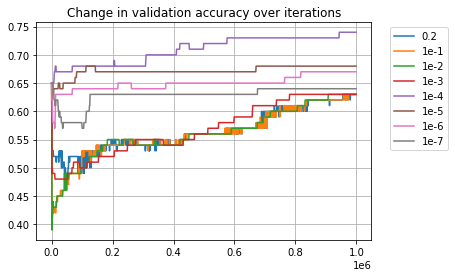

In [148]:
# Create plot
length = len(accs_list[0])
row = list(range(1, length*itv, itv))
[plt.plot(row, accs_list[i]) for i in range(len(accs_list))]
plt.legend(['0.2', '1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7'],
           bbox_to_anchor=(1.04,1))
plt.grid()
plt.title("Change in validation accuracy over iterations")
plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/lrs_compare_max_itrs=1e6.png', bbox_inches="tight")

Now, increase the max_iters and try again with [1e-4, 1e-5, 1e-6, 1e-7].

In [130]:
# configuration
new_max_iter = 3*(1e6)
new_itv = int(1e4)
new_lr_list = [1e-4, 1e-5, 1e-6, 1e-7]

In [142]:
new_accs_list = []
for i in range(len(new_lr_list)):
    result = get_acc_list(new_lr_list[i], new_max_iter, new_itv)
    print('\n')
    new_accs_list.append(result)

terminated after 3000000 iterations, with norm of the gradient equal to 0.009055883681953803
the weight found: [ 1.32319999e-01  2.81401475e-02 -1.66189784e-02 -2.77309928e-03
  1.51703686e-04  5.39611332e-02  6.17168404e-01  3.58746135e-03
 -5.56318969e+00]
time elapsed:  742.58 seconds


terminated after 3000000 iterations, with norm of the gradient equal to 0.030759426504308147
the weight found: [ 0.12950679  0.01574091 -0.02754224 -0.00150766  0.00131935  0.00407726
  0.17113651 -0.0096257  -0.98839465]
time elapsed:  744.93 seconds


terminated after 3000000 iterations, with norm of the gradient equal to 0.03569813470454591
the weight found: [ 0.13127481  0.01373776 -0.03063641 -0.00100074  0.00157156 -0.00478922
  0.02007397 -0.01208031 -0.10658963]
time elapsed:  741.24 seconds


terminated after 3000000 iterations, with norm of the gradient equal to 0.136915677637244
the weight found: [ 0.05221273  0.01255442 -0.0305826  -0.00097407  0.00148354 -0.00601824
  0.00166148  0.00064

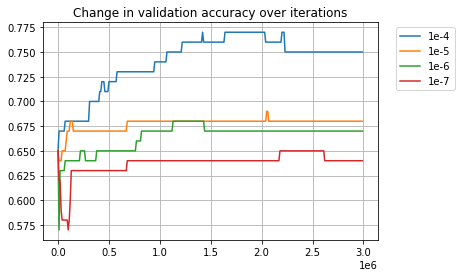

In [146]:
# Create plot
new_length = len(new_accs_list[0])
new_row = list(range(0, new_length*new_itv, new_itv))
[plt.plot(new_row, new_accs_list[i]) for i in range(len(new_accs_list))]
plt.legend(['1e-4', '1e-5', '1e-6', '1e-7'],
           bbox_to_anchor=(1.04,1))
plt.grid()
plt.title("Change in validation accuracy over iterations")
plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/lrs_compare_max_itrs=3_1e6.png',
            bbox_inches="tight")

## Best Configuration
From the plot above:

max_iters = 1.8e6

lr = 1e-4

---------------------------
epsilon=1e-4 (default value) but the norm of the gradient didn't decrease below 1e-4 in my experiments, so this parameter is not tuned.